# Verify Hashing Methods are Correctly Estimating Associated Distance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import time
from itertools import repeat
import multiprocessing
from joblib import Parallel, delayed
import pandas as pd
import subprocess
from statsmodels.stats.multitest import multipletests
from  statsmodels.stats.weightstats import ttest_ind

## minHash and Jaccard Distance

In [2]:
"""
Get Jaccard Distance from two kmer sets represented as numpy arrays
"""
def jaccard_distance(set_a: np.ndarray, set_b: np.ndarray):
    return sum(np.logical_and(set_a, set_b)) / sum(np.logical_or(set_a, set_b))

"""
Get Jaccard Distance from two signature vectors represented as numpy arrays
"""
def approx_jaccard_distance(set_a: np.ndarray, set_b: np.ndarray):
    return np.count_nonzero(set_a == set_b) / set_a.shape[0]

"""
Returns a ndarray. 
obj[0,:] is first count
"""
def build_kmer_count_matrix(fastqFile):
    """
    Return the characteristic vector for a single read, i
    """
    def get_characteristic_vector(i, fastqFile, kmer_dict, minKmerRead = 400):
        characteristicVector = np.zeros(minKmerRead, dtype=np.int16)
        kmerDir = f"../../../output/kmerTables_200bp/20mers"
        chrom = os.path.basename(fastqFile).split("_")[0]
        regionDir = os.path.join(kmerDir, chrom, os.path.basename(fastqFile)[:-6])
        tableFile = os.path.join(regionDir, f"read{i+1}.ktab") # Files are 1-indexed

        # Some regions are too small, don't have haplotypes, or too few reads and led to errors. So table doesn't exist
        if not os.path.isfile(tableFile):
            raise FileNotFoundError(tableFile)

        command = ["Tabex", tableFile, "LIST"]
        table_output = str(subprocess.check_output(command))

        for row in  table_output.split("\\n")[1:-1]: # First and last line don't contain kmers
            kmer, count = row.strip().split("=")
            kmer = kmer.split(":")[1].strip().upper()
            count = int(count.strip())

            # Get kmer index
            if kmer not in kmer_dict.keys():
                kmer_dict[kmer] = len(kmer_dict)

            localIndex = kmer_dict[kmer]
            if localIndex >= minKmerRead:
                characteristicVector = np.concatenate((characteristicVector, np.zeros(minKmerRead)), axis=0)
                minKmerRead *= 2
            characteristicVector[localIndex] = count

        return characteristicVector, kmer_dict

    vectors = []
    kmer_dict = dict()
    max_len = -1
    for i in range(100):
        try:
            char_vector, kmer_dict = get_characteristic_vector(i, fastqFile, kmer_dict, minKmerRead = max(400, len(kmer_dict)))
            if char_vector.shape[0] > max_len:
                max_len = char_vector.shape[0]
            vectors.append(char_vector)
        except:
            break
    extended_vectors = []
    for vector in vectors:
        dim_dif = max_len - vector.shape[0]
        if dim_dif == 0:
            extended_vectors.append(vector)
        else:
            temp = np.pad(vector, (0, dim_dif), mode='constant')
            extended_vectors.append(temp)
    return np.stack(extended_vectors, axis = 1)

"""
Returns signature matrix loaded from memory
"""
def build_signature_matrix(fastqFile, matrix_dir):
    signature_matrix_dir = os.path.join(matrix_dir, os.path.basename(fastqFile)[:-6]+".npy")
    return np.load(signature_matrix_dir)

"""
Return two vectors:
    jaccard_distance_matrix : real distances
    approz_jacard_dist_matx : approx distances using signature matrix
"""
def get_jaccard_dist_vectors(kmer_count_matrix: np.ndarray, signature_matrix: np.ndarray):
    n = kmer_count_matrix.shape[1]
    vector_len = (n-1)*(n-2)
    jaccard_distance_vector = np.zeros((vector_len))
    approx_jaccard_distance_vector = np.zeros((vector_len))
    index = 0
    for i in range(0, n-1):
        for j in range(i+1, n):
            jaccard_distance_vector[index] = jaccard_distance(kmer_count_matrix[:,i], kmer_count_matrix[:,j])
            approx_jaccard_distance_vector[index] = approx_jaccard_distance(signature_matrix[:,i], signature_matrix[:,j])
            index += 1
    return jaccard_distance_vector, approx_jaccard_distance_vector

"""
Test multiple regions and determine whether hash approximates real distance

B = sample size
"""
def test_many_fastqs(fastq_dir, matrix_dir, B = 100):
    p_vals = []
    jaccard_distance_vectors = []
    approx_jaccard_distance_vectors = []
    fastqs = os.listdir(fastq_dir)
    fastqs = np.random.choice(fastqs, B, replace = False)
    for fastq_file_base in fastqs:
        fastq_file = os.path.join(fastq_dir, fastq_file_base)
        try:
            kmer_count_matrix = build_kmer_count_matrix(fastq_file)
            signature_matrix = build_signature_matrix(fastq_file, matrix_dir)
            jaccard_distance_vector, approx_jaccard_distance_vector = get_jaccard_dist_vectors(kmer_count_matrix, signature_matrix)
        except:
            with open("../tmp/bad_regions", "w+") as f:
                f.write(fastq_file+"\n")
        results = ttest_ind(jaccard_distance_vector, approx_jaccard_distance_vector)
        jaccard_distance_vectors.append(jaccard_distance_vector)
        approx_jaccard_distance_vectors.append(approx_jaccard_distance_vector)
        p_vals.append(results[1])
    return p_vals, fastqs, jaccard_distance_vectors, approx_jaccard_distance_vectors,

In [3]:
fastq_dir = "../../../output/HG002_200bp/chr22"
signature_matrix_dir = "../../../output/signatureMtxs_200bp/minHash/1000,20,40"

p_vals, fastqs, jaccard_distance_vectors, approx_jaccard_distance_vectors = test_many_fastqs(fastq_dir, signature_matrix_dir, B=200)

200


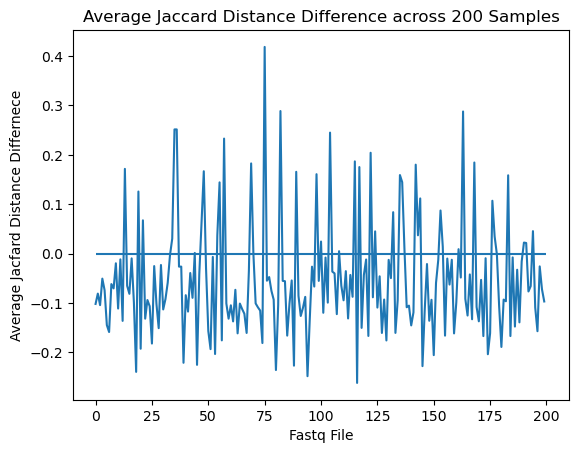

0.0
0.43210345943293194
0.9843888693647296
0.0
0.4840455366417647
1.0


(np.float64(-6.351759898078176),
 np.float64(5.820796436576285e-10),
 np.float64(398.0))

In [4]:
def plot_distances(jaccard_distance_vectors, approx_jaccard_distance_vectors):
    n = len(jaccard_distance_vectors)
    difs = [0 for _ in range(n)]
    distance = [0 for _ in range(n)]
    min_distance = [0 for _ in range(n)]
    max_distance = [0 for _ in range(n)]

    adistance = [0 for _ in range(n)]
    amin_distance = [0 for _ in range(n)]
    amax_distance = [0 for _ in range(n)]

    for i in range(n):
        difs[i] = np.mean(jaccard_distance_vectors[i] - approx_jaccard_distance_vectors[i])
        distance[i] = np.mean(jaccard_distance_vectors[i])
        min_distance[i] = np.min(jaccard_distance_vectors[i])
        max_distance[i] = np.max(jaccard_distance_vectors[i])

        adistance[i] = np.mean(approx_jaccard_distance_vectors[i])
        amin_distance[i] = np.min(approx_jaccard_distance_vectors[i])
        amax_distance[i] = np.max(approx_jaccard_distance_vectors[i])

    plt.plot(difs)
    plt.hlines(0, 0, n)
    plt.title("Average Jaccard - Approx Jaccard Distance across 200 Samples")
    plt.ylabel("Average Jaccard Distance Difference")
    plt.xlabel("Fastq File")
    plt.show()

    print(np.mean(min_distance))
    print(np.mean(distance))
    print(np.mean(max_distance))

    print(np.mean(amin_distance))
    print(np.mean(adistance))
    print(np.mean(amax_distance))

    return difs

difs = plot_distances(jaccard_distance_vectors, approx_jaccard_distance_vectors)

ttest_ind(difs, [0 for _ in range(len(difs))])

We can see from the plot that we are on average a little bit lower than 0 on average. This is confirmed in the statistical test showing that we are very confident that the approx_jaccard_distance is not the same distribution as the jaccard_distance distribution. 

Despite this, the relative value is very small and the confidence comes from a very large sample size i.e. a small variance. Then although this estimator is biased, it is only by a small amount.

In [5]:
adj_p_vals = multipletests(p_vals, alpha=0.05, method='fdr_by', maxiter=1, is_sorted=False, returnsorted=False)

## Euclidean Distance and Projection Estimation

## Cosine Distance and Sketching